<a href="https://colab.research.google.com/github/ProfessorPatrickSlatraigh/CST3512/blob/main/CST3512_Class_23_Folium_23_Nov_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CST3512 Class 23 - Folium    

**This notebook includes examples and exercises from the following:**  

 1. ['Folium and Choropleth Map: From Zero to Hero'](zero) by Sharon Li in Toward Data Science        

 2. ['Making Three Easy Maps in Python'](https://towardsdatascience.com/making-3-easy-maps-with-python-fb7dfb1036) by Ritvik Kharkar in Toward Data Science   

 3. ['Visualizing Geospatial Data Using Folium in Python'](https://www.geeksforgeeks.org/visualizing-geospatial-data-using-folium-in-python/) from Geeks for Geeks     

 

##Housekeeping    

In [1]:
# the usual suspects
import pandas as pd
import numpy as np

In [16]:
# google drive (to access files on Professor Patrick's drive)
from google.colab import drive

Mounted at /content/drive


In [32]:
# install geojson
!pip install geojson

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [33]:
# import geojson
import geojson 

In [ ]:
# install geopandas
!pip install geopandas

In [4]:
# import folium and geopandas 
import geopandas as gpd
import folium
from folium.features import GeoJsonTooltip

In [19]:
# just in case we need it
import json

---

## 1. 'Folium and Choropleth Map: From Zero to Hero'    
**by Sharon Li in Toward Data Science**         


In Python, there are several graphing libraries that you can use to plot choropleth maps such as Folium, Plotly, Matplotlib, etc. Among those, Folium is a highly specialized geospatial visualization library. It is robust and customizable and can plot choropleth maps literally in any geographic area or country with a variety of flavors and designs. It is an ideal choice for any beginners who want to get started with geospatial visualization in Python.


In this example, we will learn the core concepts of Folium and use it to create a choropleth map that visualizes the Covid-19 cases in the U.S. at the county level, with customized tooltips and layer control. The choropleth map we are going to create looks like this:


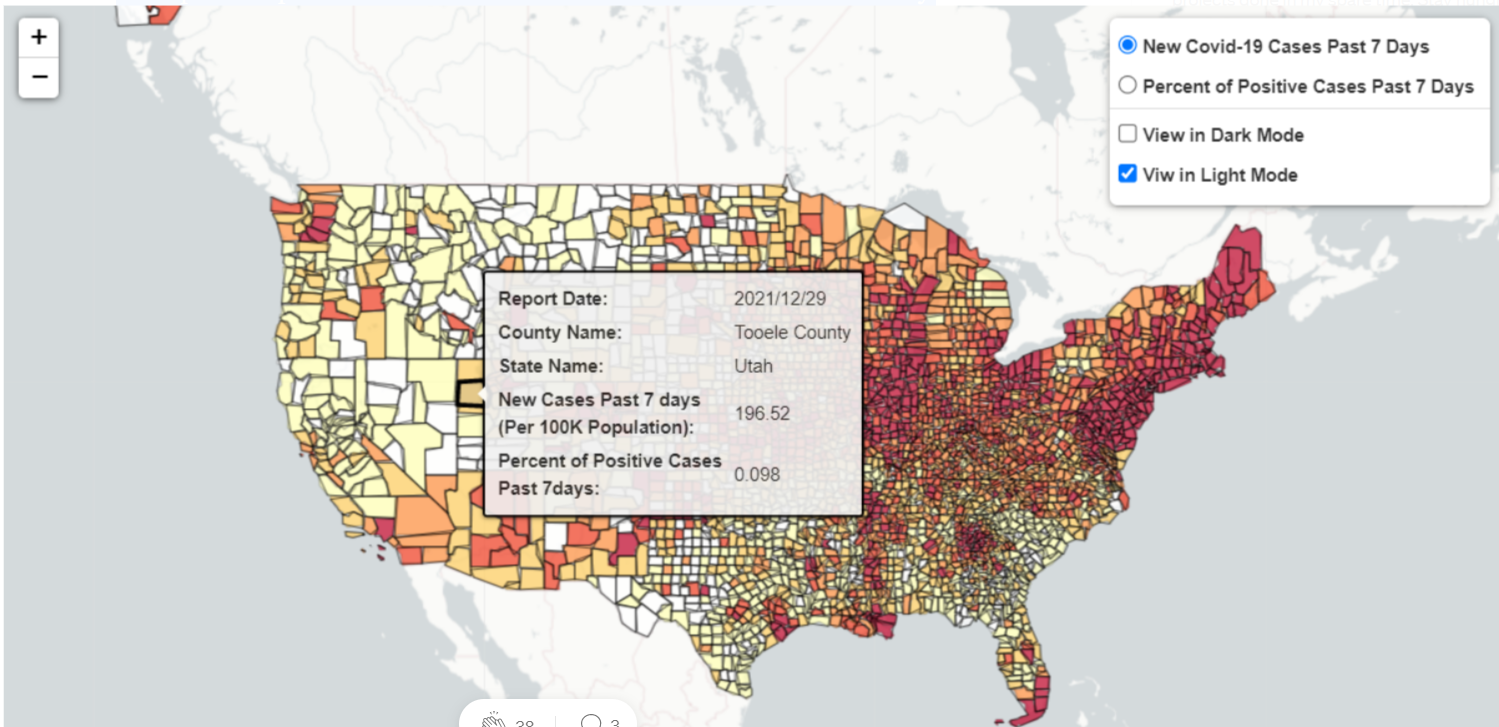

###Load requisite data files   

Making Choropleth Maps requires two main types of input:

1. A GeoJSON file that contains the geometry information and defines the boundaries of the pre-defined geographic areas (e.g., countries, U.S. counties, zip codes, etc.)


2. A tabular dataset that contains the geographic area identifiers (e.g., country names, county fips code, zip code, etc.) and metrics that we want to visualize in the map (e.g., population, unemployment rate, etc.)



#### Mount Google Drive to access the geojson file     

In [39]:
# be sure that you have a ready copy of the geojson file on your drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


####1. Read the `geojson` map data file    

<i><u>note:</u></i>    
*because the source `.geojson` file is over 100mb and not accessible via a `GitHub` repo,*    
*it will need to be loaded to a mounted drive for reading.*     

*The source file is available for download at [PublicDataSoft](https://public.opendatasoft.com/explore/dataset/georef-united-states-of-america-county/export/?disjunctive.ste_code&disjunctive.ste_name&disjunctive.coty_code&disjunctive.coty_name&sort=year) or from [a copy on Professor Patrick's Google Drive]().*    

This notebook uses the file `georef-united-states-of-america-county.geojson` mounted on a local Google Drive at:    

```    

/content/drive/MyDrive/geo/georef-united-states-of-america-county.geojson    


```    



In [37]:
#Read the geoJSON file using geopandas
geojson = gpd.read_file('/content/drive/MyDrive/geo/georef-united-states-of-america-county.geojson')

# only select 'coty_code' (GEO_ID or county fips) and 'geometry' columns
geojson=geojson[['coty_code','geometry']] 

In [ ]:
geojson.head()

####2. Read the CDC Covid-19 data file    

In [47]:
#Read the covid-19 data using pandas
covid_df = pd.read_csv(r'https://raw.githubusercontent.com/ProfessorPatrickSlatraigh/data/main/United_States_COVID-19_County_Level_of_Community_Transmission_2022-Q1.csv')

In [48]:
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289975 entries, 0 to 289974
Data columns (total 7 columns):
 #   Column                                              Non-Null Count   Dtype  
---  ------                                              --------------   -----  
 0   state_name                                          289975 non-null  object 
 1   county_name                                         289975 non-null  object 
 2   fips_code                                           289975 non-null  int64  
 3   report_date                                         289975 non-null  object 
 4   cases_per_100K_7_day_count_change                   289375 non-null  object 
 5   percent_test_results_reported_positive_last_7_days  252990 non-null  float64
 6   community_transmission_level                        289765 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 15.5+ MB


###Data Wrangling    

This dataset keeps track of Covid-19 metrics at the U.S. county level for each report_date. Since we are creating a static choropleth map, we’ll limit our data frame to the most recent report_date (i.e. 02/01/2022 in our example).    

We also need to do a bit of data wrangling to clean some of the data fields. We will change the data type of `fips_code` to string and fill the leading zero if it’s missing. We’ll also create two new columns `new_cases_7days` and `pct_positive_7days` that have correct data types and formats and drop the original columns.    

In [49]:
#change the data type of 'fips_code' to string and fill the leading zero
covid_df["fips_code"] = covid_df["fips_code"].map(str)
covid_df["fips_code"] = covid_df["fips_code"].str.zfill(5)

In [44]:
#Filter the dataframe to only show records for 2022/02/01
covid_df = covid_df[(covid_df['report_date'] =='2022/02/01')]

In [50]:
#create two new columns with correct data types and formats...
covid_df['new_cases_7days']    = covid_df['cases_per_100K_7_day_count_change'].str.replace(',', '')
covid_df['new_cases_7days']    = covid_df['new_cases_7days'].replace({'suppressed': np.nan}).astype(float)
covid_df['pct_positive_7days'] = covid_df['percent_test_results_reported_positive_last_7_days']/100

# ... then drop the original columns.
covid_df.drop(['cases_per_100K_7_day_count_change', 'percent_test_results_reported_positive_last_7_days',
              'community_transmission_level'], axis=1, inplace=True)

In [51]:
covid_df.head()

,state_name,county_name,fips_code,report_date,new_cases_7days,pct_positive_7days
0,Alabama,Barbour County,01005,2022/01/01,506.36,0.2500
1,Alabama,Chilton County,01021,2022/01/01,357.88,0.2064
2,Alabama,Choctaw County,01023,2022/01/01,452.78,0.0172
3,Alabama,Clay County,01027,2022/01/01,672.46,0.2982
4,Alabama,Cleburne County,01029,2022/01/01,422.54,0.3600


Lastly, let’s join the `geojson` with `covid_df` to create our final dataset that’s ready for visualization.      

By joining the two datasets, we ensure that the `fips_code` in the `covid_df data` frame matches exactly the `coty_code` in the GeoJSON file, which is critical later on when using Folium to plot the choropleth map.    


In [52]:
#Join the geojson file with covid_df
df_final = geojson.merge(covid_df, left_on="coty_code", right_on="fips_code", how="outer") 
df_final = df_final[~df_final['geometry'].isna()] 


In [53]:
df_final.head()

,coty_code,geometry,state_name,county_name,fips_code,report_date,new_cases_7days,pct_positive_7days
0,17001,"POLYGON ((-90.91197 40.19309, -90.91349 40.193...",Illinois,Adams County,17001,2022/01/01,787.04,0.1654
1,17001,"POLYGON ((-90.91197 40.19309, -90.91349 40.193...",Illinois,Adams County,17001,2022/01/02,787.04,0.1699
2,17001,"POLYGON ((-90.91197 40.19309, -90.91349 40.193...",Illinois,Adams County,17001,2022/01/03,787.04,0.1816
3,17001,"POLYGON ((-90.91197 40.19309, -90.91349 40.193...",Illinois,Adams County,17001,2022/01/04,1098.80,0.1808
4,17001,"POLYGON ((-90.91197 40.19309, -90.91349 40.193...",Illinois,Adams County,17001,2022/01/05,1155.35,0.1799


###Creating the Choropleth Map with Folium     

####Step 1 - Initiate a Base Map    


To create a choropleth map using folium, we need to first initiate a base map by using `folium.Map()` and then add layers to it. We can pass the starting coordinates to the map by using the location parameter. The starting coordinates we choose here (40,-96) approximately represent the center of the U.S.A. map.    

We can select the desired map tile (e.g. `tiles=”Stamen Terrain”`) from a list of built-in tilesets — the default one is `OpenStreetMap`, or simply leave the tile option to `‘None’`. We can also set the initial zoom level for the map using the `zoom_start` parameter.    



In [55]:
# creating a base USA map with Folium
us_map = folium.Map(location=[40, -96], zoom_start=4,tiles='openstreetmap')
us_map


####Step2: Add Choropleth Map Layer to the Base Map    

The base map is initially empty. We can create the choropleth map layer using `folium.Choropleth()` and add it to the base map using `add_to()` method.     

Within the `folium.Choropleth()` function, there are a few import parameters we need to specify:    


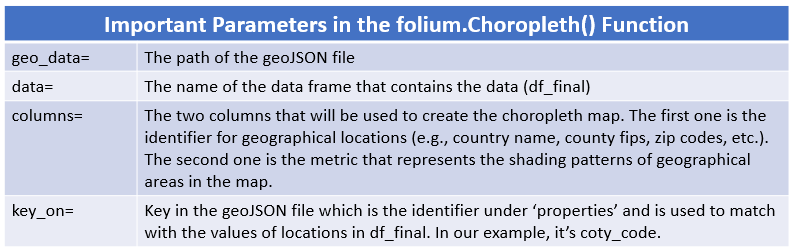

---